# Convergence Analysis of the Conditional Gradient Algorithm for the RankSVM

We analyse different step-size algorithms and stopping criteria for the RankSVM and their influence on the convergence. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset

## Load Example Data

We work with the five datasets used in the ECCB 2018 publication. Those include retention times measured on different chromatographic systems.

In [3]:
X, y, mol = read_dataset("./ECCB2018_data.csv")
print("Number of Measurements:", len(X))

datasets = y.get_unique_dss()
print("Datasets:", datasets)

Number of Measurements: 1081
Datasets: ['Eawag_XBridgeC18', 'FEM_long', 'LIFE_old', 'RIKEN', 'UFZ_Phenomenex']


## Separate Data into Training and Test Set

In [4]:
train, test = next(GroupKFold(n_splits=3).split(X, y, groups=mol))
print("(n_train, n_test) = (%d, %d)" % (len(train), len(test)))
assert not (set(mol[train]) & set(mol[test]))

X_train, X_test = X[train], X[test]
y_train, y_test = y[train], y[test]

(n_train, n_test) = (720, 361)


## Train RankSVM Models using different Step-size Calculation

We compare four step-size calculation approaches. Three formulas resulting in a simple diminishing step-size depending on the iteration $k$. The last determines the optimal step-size $\tau^{(k)}$ using line-search.

1) ```diminishing```: $$\tau^{(k)}\leftarrow\frac{2}{k + 2}$$
2) ```linesearch```: $$\tau^{(k)}\leftarrow\frac{\mathbf{1}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})-\mathbf{\alpha}^T\mathbf{A}\mathbf{K}\mathbf{A}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})}{(\mathbf{s}-\mathbf{\alpha}^{(k)})^T\mathbf{A}\mathbf{K}\mathbf{A}^T(\mathbf{s}-\mathbf{\alpha}^{(k)})}$$

Here, $\tau^{(0)}$ is the initial step-size, and $k$ is the current iteration (starting with $k=0$), and $C$ is the regularization parameter of the RankSVM.

In [5]:
# Define some of the RankSVM parameters
pair_generation = "random"  
random_state = 9400
C = 1
alpha_threshold = 1e-2
kernel = "minmax"

# Train multiple RankSVMs
ranksvms = {}
for ss in ["diminishing", "linesearch"]:
    print("Train using:", ss)
    ranksvms[ss] = KernelRankSVC(
        kernel=kernel, pair_generation=pair_generation, random_state=random_state, alpha_threshold=alpha_threshold, debug=True, 
        C=C, step_size=ss).fit(X_train, y_train)

Train using: diminishing
Converged: k = 260, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00009 <= 0.00010
Train using: linesearch
Converged: k = 120, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00010 <= 0.00010


### Analyse the RankSVMs

In [6]:
analyzer = RankSVMAnalyzer(ranksvms)  # load RankSVMs into the analyser

#### Step-size Values

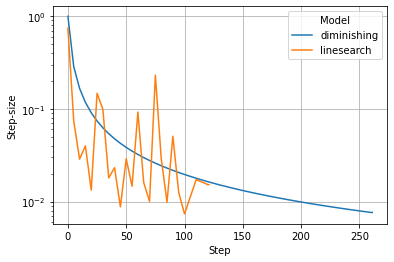

In [7]:
analyzer.plot_step_size()

#### Objective Values

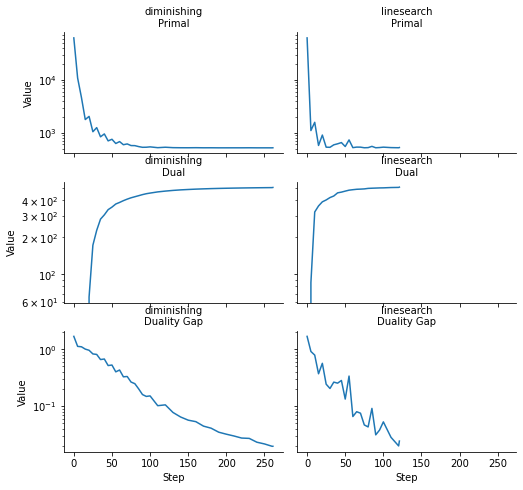

In [8]:
analyzer.plot_objective_functions(height=2.25, aspect=1.65, sharex=True)

The step-size approaches have different convergence, i.e. minimizing the duality gap, speed. The fastest convergence is achieved by the line-search strategy, which reaches the desired duality gap already after 300 iterations. The approache ```diminishing``` perform very similar with a slower convergence in the beginning, but a better final duality gap.

For our experiments we use a relative duality gap defined as: $$\frac{primal - dual}{|primal| + 1}$$

#### Performance on Training and Validation Set

            Training Accuracy        Validation Accuracy       
                         amax median                amax median
Model                                                          
diminishing               0.9   0.89                0.87   0.85
linesearch                0.9   0.89                0.87   0.85


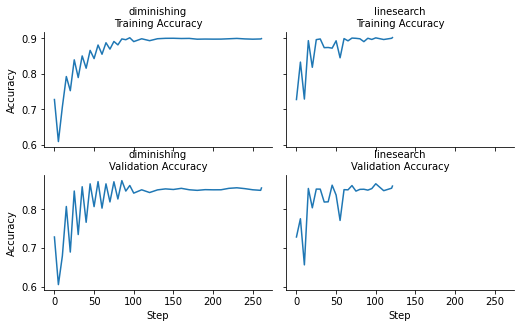

In [9]:
analyzer.plot_accuracies(height=2.25, aspect=1.65)

Interestingly, despite being the step-size approach with the slowest convergence, ```diminishing_1``` reaches the best training set performance (around 0.9) the earliest. The model performance also remains stable on both training and validation set. That we cannot observe any performance change for ```diminishing_1``` could be related ot its fast decay of the step-size (see previous Figure). The line-search appraoch shows a higher variation and the remaining two diminishing strategies show a behavior between ```diminishing_1``` and ```linesearch```.

### Analysis depending on different Parameters

In [10]:
# Define some of the RankSVM parameters
pair_generation = "random"  
random_state = 9400
alpha_threshold = 1e-2
kernel = "minmax"
max_iter = 500

# Train multiple RankSVMs
ranksvms = {}
for ss in ["diminishing", "linesearch"]: 
    for C in [2 ** (-2), 2 ** 0, 2 ** 2, 2 ** 4]:
        print("Train using:", (ss, C))
        ranksvms["%s__C=%02.2f" % (ss, C)] = KernelRankSVC(
            kernel=kernel, pair_generation=pair_generation, random_state=random_state, alpha_threshold=alpha_threshold, debug=True, 
            C=C, step_size=ss, max_iter=max_iter).fit(X_train, y_train)

Train using: ('diminishing', 0.25)
Converged: k = 210, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00010 <= 0.00010
Train using: ('diminishing', 1)
Converged: k = 260, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00009 <= 0.00010
Train using: ('diminishing', 4)
Converged: k = 350, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00008 <= 0.00010
Train using: ('diminishing', 16)
Converged: k = 330, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00008 <= 0.00010
Train using: ('linesearch', 0.25)
Converged: k = 80, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00007 <= 0.00010
Train using: ('linesearch', 1)
Converged: k = 120, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00010 <= 0.00010
Train using: ('linesearch', 4)
Converged: k = 200, Relative duality gap (to gap_0) below threshold: gap / gap_0 = 0.00009 <= 0.00010
Train using: ('linesearch', 16)
Converged: k = 80, Relative

#### C=16, Different Step-size Approaches

diminishing__C=16.00 Min alpha = 0.00000, Max alpha = 16.00000
linesearch__C=16.00 Min alpha = 0.05289, Max alpha = 16.00000


<Figure size 432x288 with 0 Axes>

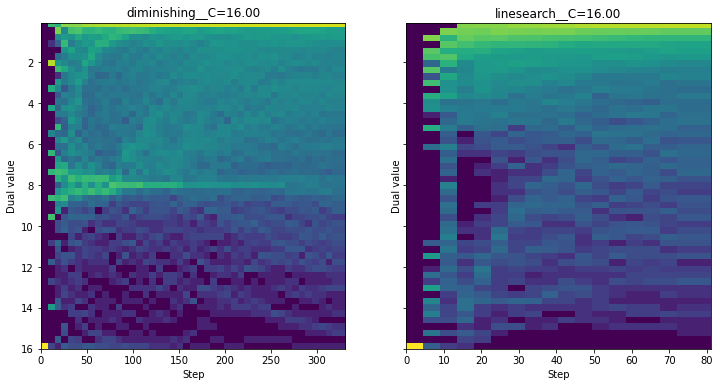

In [11]:
analyzer = RankSVMAnalyzer({k: v for k, v in ranksvms.items() if k.find("__C=16") >= 0})  # load RankSVMs into the analyser
_ = analyzer.plot_alphas(zscale="log")

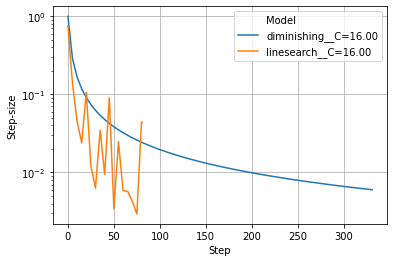

In [12]:
analyzer.plot_step_size()

                     Training Accuracy        Validation Accuracy       
                                  amax median                amax median
Model                                                                   
diminishing__C=16.00              0.92   0.86                0.88   0.84
linesearch__C=16.00               0.92   0.90                0.89   0.87


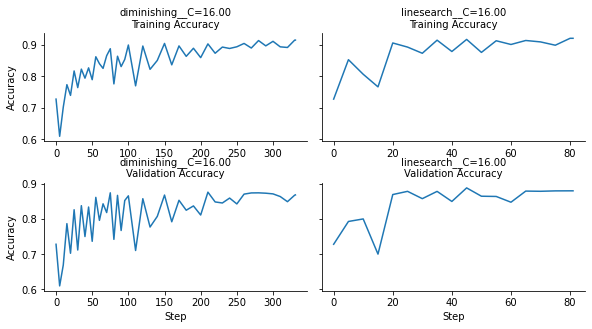

In [13]:
analyzer.plot_accuracies(height=2.25, aspect=1.85, sharex=False)

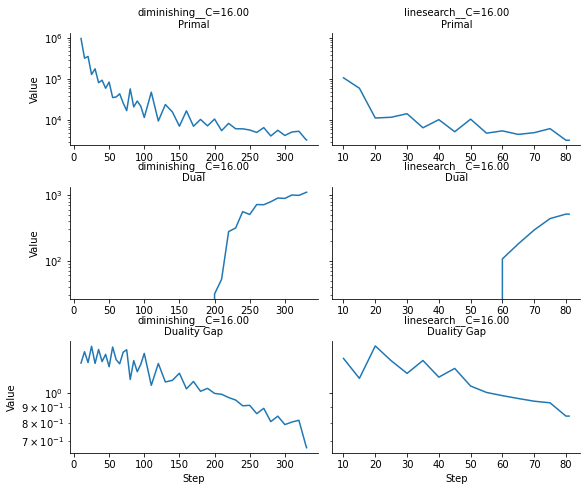

In [14]:
analyzer.plot_objective_functions(height=2.25, aspect=1.85, skip_measurements=2, sharex=False)